In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using TrajOptPlots
const MOI = MathOptInterface
using Random
using Plots
using Rotations
include("quadruped.jl")
include("sparseblocks.jl")
include("quadratic_cost.jl")
include("nlp.jl")
include("moi.jl")

  Activating environment at `C:\Users\pnadan\Documents\GitHub\Optimal-Control-Project\Project.toml`


WebIO._IJuliaInit()

solve

## Dynamics Models

In [22]:
include("simple_quadruped.jl")
full_model = UnitreeA1()
n,m = state_dim(full_model), control_dim(full_model)
mvis = initialize_visualizer(full_model);
model = simplifyQuadruped(full_model)
n,m = state_dim(model), control_dim(model);

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat C:\Users\pnadan\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


## Reference Trajectory & Contact Sequence

In [49]:
include("ref_trajectory.jl")
include("gait.jl")

# Discretization
tf = 4.9
dt = 0.1
N = Int(ceil(tf/dt)) + 1
times = range(0,tf, length=N);

# Contact Sequence
M = 10 # NOTE: check later, is this physically feasible w/ our dt
contact_sched = contact_sequence_trot(times, M)

# Reference Trajectory
Xref,Uref = reference_trajectory(model, times, contact_sched, xterm=0);

## Define NLP for IPOPT

In [55]:
include("moi.jl")
include("nlp.jl")
include("nlp_cost.jl")
include("nlp_constraint.jl")

# Define cost function
Q = Diagonal([10; 1; 10; fill(1.0, 16); 10; 1; 10; fill(1.0, 15)]);
# Q = Diagonal([1; 10; fill(1.0, 5); fill(0, 12); 1; 10; fill(1.0, 4); fill(0, 12)]);
R = Diagonal(fill(1e-3,12))
Qf = Q;
obj = map(1:N-1) do k
    LQRCost(Q,R,Xref[k],Uref[k])
end
push!(obj, LQRCost(Qf, R, Xref[N], Uref[N-1]))

# Unit test: constraint Jacobian matches result from ForwardDiff
# let
#     nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, use_sparse_jacobian=true);
#     Random.seed!(1)
#     Xguess = [x + 0.1*randn(length(x)) for x in Xref]
#     Uguess = [u + 0.1*randn(length(u)) for u in Uref]
#     Z0 = packZ(nlp, Xguess, Uguess);
#     initialize_sparsity!(nlp)
#     rc = getrc(nlp.blocks)
#     r = [t[1] for t in rc]
#     c = [t[2] for t in rc]
#     jacvec = zeros(length(rc))
#     jac_c!(nlp, jacvec, Z0)
#     jac = sparse(NonzerosVector(jacvec, nlp.blocks));
    
#     jac_n = ForwardDiff.jacobian(x->eval_c!(nlp, zeros(eltype(x), num_duals(nlp)), x), Z0)
#     for i = 1:5
#         println(jac[nlp.cinds[i],:] ≈ jac_n[nlp.cinds[i],:])
#     end
# end

# Define the NLP
nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, use_sparse_jacobian=true);
Random.seed!(1)
Xguess = [x + 0.1*randn(length(x)) for x in Xref]
Uguess = [u + 0.1*randn(length(u)) for u in Uref]
Z0 = packZ(nlp, Xguess, Uguess);

## Solve NLP

In [56]:
Z_sol, solver = solve(Z0, nlp, c_tol=1e-6, tol=1e-4, max_iter=500)

Creating NLP Block Data...
Creating Ipopt...
Adding constraints...
starting Ipopt Solve...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   158856
Number of nonzeros in inequality constraint Jacobian.:     7400
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2438
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2087
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       

([-1.1945314292063194e-18, -1.3535164698992983e-18, 0.2, 0.999999999999907, -1.5655891332893188e-19, 1.9381554409927328e-20, 3.3259045654150384e-19, 0.183, 0.04700000000000012, 4.1329001870465645e-20  …  -8.42797915283205e-21, 4.6068290363844427e-20, -1.1500885989591259e-20, 7.510371834778787e-21, 3.557714078193273e-20, -3.534371331683612e-21, -7.517180884990498e-21, 7.456444379439479e-18, -1.4967152992558316e-17, 7.004916868403038e-22], Ipopt.Optimizer)

## Controller

In [53]:
# include("controller.jl")
# Xsol,Usol = unpackZ(nlp,Z0)
# A = [zeros(n,n) for k = 1:N-1]
# B = [zeros(n,m) for k = 1:N-1]
# for k = 1:N-1
#     A[k], B[k] = discrete_jacobian(nlp.model, Xsol[k], Usol[k], nlp.times[k], nlp.times[k+1]-nlp.times[k], [0 0 0 0])
# end
# K, P = tvlqr(A,B,Q,R,Qf)

## Simulation

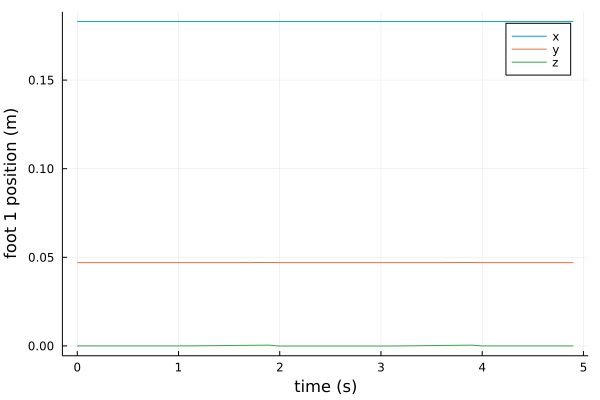

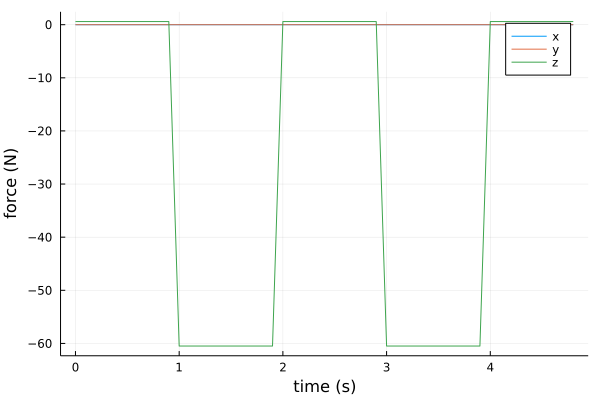

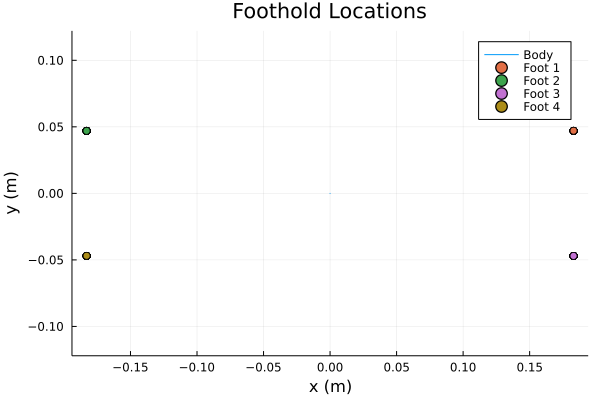

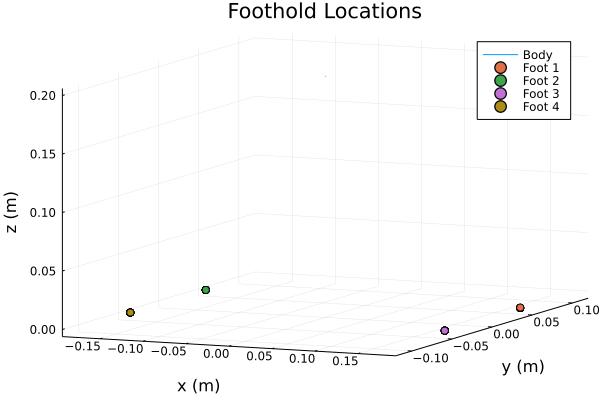

In [58]:
Xsol,Usol = unpackZ(nlp,Z_sol)
# Xsol,Usol = unpackZ(nlp,Z0)
# Xsol,Usol = Xref, Uref
Xmat = zeros(N, n)
for k = 1:N
    Xmat[k,:] = Xsol[k]
end
Umat = zeros(N-1, m)
for k = 1:N-1
    Umat[k,:] = Usol[k]
end

f1 = nlp.modes[1,:] .== 0
f2 = nlp.modes[2,:] .== 0
f3 = nlp.modes[3,:] .== 0
f4 = nlp.modes[4,:] .== 0

# display(plot(nlp.times, Xmat[:,1:3], label = ["x" "y" "z"], xlabel="time (s)", ylabel="body position (m)"))
display(plot(nlp.times, Xmat[:,8:10], label = ["x" "y" "z"], xlabel="time (s)", ylabel="foot 1 position (m)"))
display(plot(nlp.times[1:N-1], Umat[:,4:6], label = ["x" "y" "z"], xlabel="time (s)", ylabel="force (N)"))

plot(Xmat[:,1], Xmat[:,2], xlabel="x (m)", ylabel="y (m)", label = "Body")
scatter!(Xmat[f1,8], Xmat[:,9], label = "Foot 1")
scatter!(Xmat[f2,11], Xmat[:,12], label = "Foot 2")
scatter!(Xmat[f3,14], Xmat[:,15], label = "Foot 3")
display(scatter!(Xmat[f4,17], Xmat[:,18], label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

plot3d(Xmat[:,1], Xmat[:,2], Xmat[:,3], xlabel="x (m)", ylabel="y (m)", zlabel="z (m)", label = "Body")
scatter3d!(Xmat[f1,8], Xmat[:,9], Xmat[:,10], label = "Foot 1")
scatter3d!(Xmat[f2,11], Xmat[:,12], Xmat[:,13], label = "Foot 2")
scatter3d!(Xmat[f3,14], Xmat[:,15], Xmat[:,16], label = "Foot 3")
display(scatter3d!(Xmat[f4,17], Xmat[:,18], Xmat[:,19], label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

# plot3d(Xmat[:,1], Xmat[:,2], Xmat[:,3], xlabel="x (m)", ylabel="y (m)", zlabel="z (m)", label = "Body")
# plot3d!(Xmat[:,8], Xmat[:,9], Xmat[:,10], label = "Foot 1")
# plot3d!(Xmat[:,11], Xmat[:,12], Xmat[:,13], label = "Foot 2")
# plot3d!(Xmat[:,14], Xmat[:,15], Xmat[:,16], label = "Foot 3")
# display(plot3d!(Xmat[:,17], Xmat[:,18], Xmat[:,19], label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

## Model Limitations
* No impulse on body from foot impact
* Swing feet can slide on floor (instead of lifting off along some spline)
* No normal force limits
* No friction cone limits